In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [19]:

!pip install protobuf==3.20.3 --force-reinstall --no-deps



print("Protobuf downgraded!.")

# to save our notebook from version conflicts

  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
Protobuf downgraded!.


# All  important libararies

In [20]:

# All  important libararies


import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")


# Data Visualization

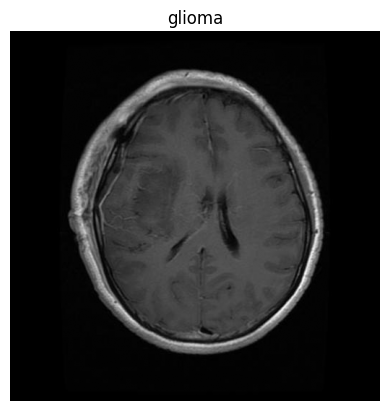

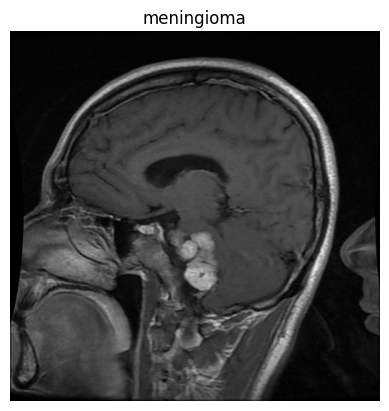

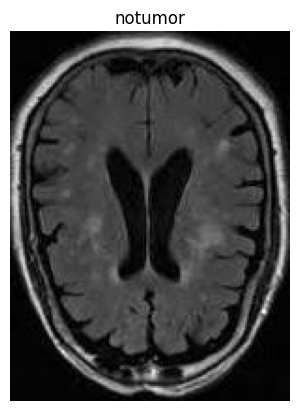

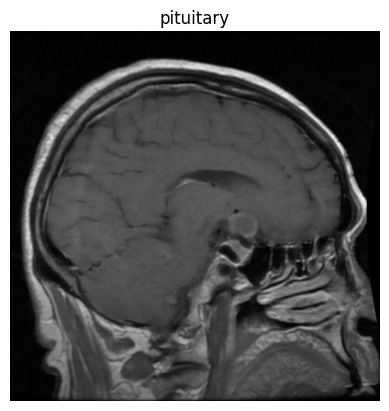

In [21]:
import os, random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# paths of 4 class folders
paths = {
    "glioma": "/kaggle/input/brain-tumor-mri-dataset/Training/glioma",
    "meningioma": "/kaggle/input/brain-tumor-mri-dataset/Training/meningioma",
    "notumor": "/kaggle/input/brain-tumor-mri-dataset/Training/notumor",
    "pituitary": "/kaggle/input/brain-tumor-mri-dataset/Training/pituitary",
}

# display random image from every class
for label, folder in paths.items():
    img_name = random.choice(os.listdir(folder))
    img_path = os.path.join(folder, img_name)

    img = mpimg.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')
    plt.show()


# Data Augmentation

In [22]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Medical Standard Augmentation Performed

train_dir = "/kaggle/input/brain-tumor-mri-dataset/Training"


from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=(0.95, 1.05),
    brightness_range=(0.9, 1.1),
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2   # for validation 
)


# Loading and praparing the Dataset for Training 

In [23]:

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299,299),
    batch_size=32,
    class_mode='categorical',
    subset="training",
    shuffle=True
)


val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299,299),
    batch_size=32,
    class_mode='categorical',
    subset="validation",
    shuffle=False
)



Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


# Importing  Callbacks functions

In [24]:
from tensorflow.keras.callbacks import (
    ModelCheckpoint,  # this ensures to save best model .
    EarlyStopping, 
    ReduceLROnPlateau 
)

 # EarlyStopping, 

            # when validation loss is not decreasing. then it 
            # automatically  stop the training.

 
# ReduceLROnPlateau 
           # when accuracy is not improving then it reduce the
           # elarmg rate in order to catch fine details.

# Defining Callbacks (regularizations)

In [25]:
# 1. Sav BEST model (based on validation accuracy)

checkpoint_cb = ModelCheckpoint(
    "best_xception_model(1).keras",   # file name
    monitor="val_accuracy",        # to define best at which matrics
    save_best_only=True,           # to save only best
    verbose=1
)

# 2. Early stopping (overfitting control)
earlystop_cb = EarlyStopping(
    monitor="val_loss",       # to see validation loss
    patience=3,              # if not improvemnet till 3 epoch , stop training 
    restore_best_weights=True,     # back best epoch  weights 
    verbose=1
)

# 3. here we are defining learning rate when model gets stucks.
reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,                   
    patience=2,
    min_lr=1e-6,
    verbose=1
)


# Loading and Defining Pretrained Model Xception

In [28]:
# 1. Input shape 
img_shape = (299, 299, 3)


# 2. Base Model : Xception (Pretrained Feature Extractor)
base_model = tf.keras.applications.Xception(
    include_top=False,          # ImageNet classifier remove
    weights="imagenet",         # Pretrained weights
    input_shape=img_shape,      # Input image size
    )


# include_top=False,    
          # ImageNet classifier remove
          # it  means we just extracting important features 
          # from 1000 calssses anot classfing from 1000 classes like 
          # like in 1000 it have dog cat etc etc.. but we have mri ...


# Model Architecture

In [29]:
# 3. Full Model (Classifier on top of Xception)
model = Sequential([
    base_model, # Feature extractor
    GlobalAveragePooling2D(),# 
    Dropout(0.3),# Regularization 
    Dense(128, activation='relu'),
    Dropout(0.25),  # More regularization
    Dense(4, activation='softmax')# Output layer (4 classes)
])

# Compling the Model 

In [31]:
# 4. Compile the model
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(),
        Recall()
    ])


# Model Summary 

In [32]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

# Fitting the Model 

In [33]:

# TRAINING


history = model.fit(
    train_gen,
    epochs=30,                     # upper limit
    validation_data=val_gen,
    callbacks=[
        checkpoint_cb, # here cb is just callback 
        earlystop_cb,
        reduce_lr_cb
    ],
    shuffle=False
)


Epoch 1/30


I0000 00:00:1767631791.516524     185 service.cc:152] XLA service 0x7c6634004d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767631791.516569     185 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1767631794.480017     185 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-01-05 16:50:14.384898: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-05 16:50:14.624074: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-05 16:50:16.000178: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accur

142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.8456 - loss: 0.3979 - precision_1: 0.9047 - recall_1: 0.7881

2026-01-05 16:52:52.684593: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-05 16:52:52.924729: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-05 16:52:54.015708: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-05 16:52:54.280816: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-05 16:52:59.816630: E external/local_xla/xla/stream_

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8461 - loss: 0.3969 - precision_1: 0.9048 - recall_1: 0.7888   

2026-01-05 16:54:22.475216: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-05 16:54:22.713661: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-05 16:54:23.734027: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-05 16:54:23.996657: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_accuracy improved from -inf to 0.75723, saving model to best_xception_model(1).keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.8465 - loss: 0.3959 - precision_1: 0.9050 - recall_1: 0.7895 - val_accuracy: 0.7572 - val_loss: 1.4439 - val_precision_1: 0.7672 - val_recall_1: 0.7511 - learning_rate: 0.0010
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.9688 - loss: 0.1008 - precision_1: 0.9702 - recall_1: 0.9661
Epoch 2: val_accuracy improved from 0.75723 to 0.76512, saving model to best_xception_model(1).keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 129s 898ms/step - accuracy: 0.9688 - loss: 0.1006 - precision_1: 0.9703 - recall_1: 0.9662 - val_accuracy: 0.7651 - val_loss: 0.7620 - val_precision_1: 0.7738 - val_recall_1: 0.7555 - learning_rate: 0.0010
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.9823 - loss: 0.0594 - precision_1: 0.9843 - recall_1: 0.9806
Epoch 3: val_accuracy improved from 0.76512 to 0.96670, saving model to bes

# Learning Curve

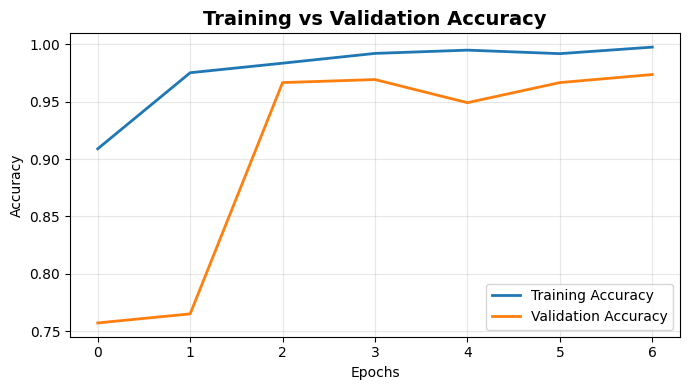

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))

plt.plot(
    history.history['accuracy'],
    label='Training Accuracy',
    linewidth=2
)

plt.plot(
    history.history['val_accuracy'],
    label='Validation Accuracy',
    linewidth=2
)

plt.title("Training vs Validation Accuracy", fontsize=14, weight='bold')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Loss Curve 

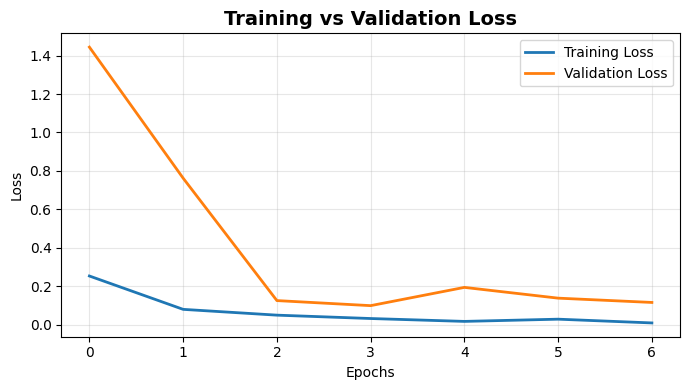

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))

plt.plot(
    history.history['loss'],
    label='Training Loss',
    linewidth=2
)

plt.plot(
    history.history['val_loss'],
    label='Validation Loss',
    linewidth=2
)

plt.title("Training vs Validation Loss", fontsize=14, weight='bold')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Loading our best Saved Model

In [38]:
import tensorflow as tf
from tensorflow.keras.models import load_model

model = load_model(
    "best_xception_model(1).keras",
    custom_objects={
        "Precision": tf.keras.metrics.Precision,
        "Recall": tf.keras.metrics.Recall
    }
)


# Loading our Test Data

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_dir = "/kaggle/input/brain-tumor-mri-dataset/Testing"

test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299,299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1311 images belonging to 4 classes.


# Test Accuracy 

In [40]:
test_loss, test_acc, test_prec, test_rec = model.evaluate(
    test_gen,
    verbose=1
)

print(f"Test Accuracy : {test_acc*100:.2f}%")
print(f"Test Precision: {test_prec*100:.2f}%")
print(f"Test Recall   : {test_rec*100:.2f}%")


40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9881 - loss: 0.0511 - precision_1: 0.9881 - recall_1: 0.9881

2026-01-05 17:10:09.956520: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-05 17:10:10.197786: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-05 17:10:11.301708: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-05 17:10:11.568184: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 663ms/step - accuracy: 0.9881 - loss: 0.0509 - precision_1: 0.9881 - recall_1: 0.9881
Test Accuracy : 98.93%
Test Precision: 98.93%
Test Recall   : 98.93%


# Saving Test Metrics

In [41]:
import pandas as pd

# Creating DataFrame
results_df = pd.DataFrame({
    "Metric": ["Loss", "Accuracy", "Precision", "Recall"],
    "Value": [test_loss, test_acc, test_prec, test_rec]
})

# Save to CSV
results_df.to_csv("test_metrics(VS).csv", index=False)

print("test_metrics(VS).csv")


test_metrics(VS).csv


# Confusion matrix on Validation 

36/36 ━━━━━━━━━━━━━━━━━━━━ 44s 927ms/step
Confusion Matrix:
[[261   2   0   1]
 [  0 262   5   0]
 [  6  10 295   8]
 [  0   4   1 286]]

Normalized Confusion Matrix:
[[0.99 0.01 0.   0.  ]
 [0.   0.98 0.02 0.  ]
 [0.02 0.03 0.92 0.03]
 [0.   0.01 0.   0.98]]


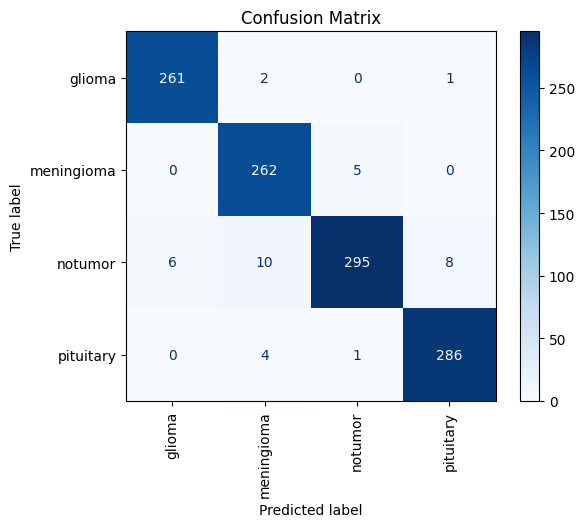


Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.99      0.98       264
  meningioma       0.94      0.98      0.96       267
     notumor       0.98      0.92      0.95       319
   pituitary       0.97      0.98      0.98       291

    accuracy                           0.97      1141
   macro avg       0.97      0.97      0.97      1141
weighted avg       0.97      0.97      0.97      1141



In [42]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Important: Generator reseting
val_gen.reset()

# Predictions k
y_pred_prob = model.predict(val_gen, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)

y_true = val_gen.classes

# Confusion Matrix calculating
cm = confusion_matrix(y_true, y_pred)

# Print
print("Confusion Matrix:")
print(cm)

# Normalized (percentage)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print("\nNormalized Confusion Matrix:")
print(np.round(cm_norm, 2))

# Plotting ( heatmap)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_gen.class_indices.keys()))
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

#  Classification report (precision, recall, f1)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(val_gen.class_indices.keys())))


# Plotting Roc Curve

41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 346ms/step


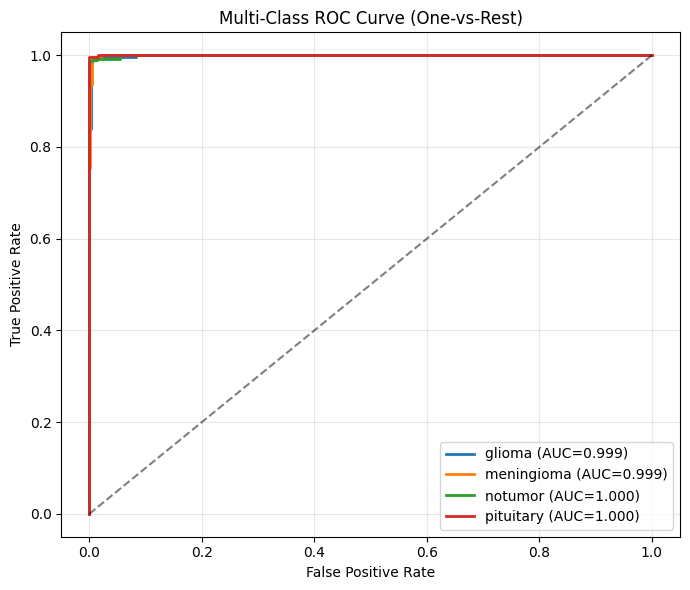

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1. Reset generator

test_gen.reset()


# 2. Predictions
y_pred_prob = model.predict(test_gen, verbose=1)
y_true = test_gen.classes


# 3. Binarize true labels 

num_classes = y_pred_prob.shape[1]
y_true_bin = label_binarize(y_true, classes=range(num_classes))

class_names = list(test_gen.class_indices.keys())


# 4. Plotting  ROC for each class

plt.figure(figsize=(7, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=2, label=f"{class_names[i]} (AUC={roc_auc:.3f})")

# Random guess line
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve (One-vs-Rest)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



# Saving Classification report

In [51]:
from sklearn.metrics import classification_report
import pandas as pd


min_len = min(len(y_true), len(y_pred))
y_true = y_true[:min_len]
y_pred = y_pred[:min_len]

pd.DataFrame(
    classification_report(
        y_true,
        y_pred,
        target_names=list(val_gen.class_indices.keys()),
        output_dict=True
    )
).transpose().to_csv("val_classification_report(VS).csv")

print("Classification report saved as val_classification_report(VS).csv")


Classification report saved as val_classification_report(VS).csv


In [52]:
import os

print(os.getcwd())          # current directory
print(os.listdir())         # files in current directory


/kaggle/working
['best_xception_model(1).keras', 'val_classification_report(VS).csv', 'test_metrics(VS).csv', '.virtual_documents']


# Saving full Test prediction in csv

In [54]:
import numpy as np
import pandas as pd


test_gen.reset()


y_pred_prob = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)

# 3. True labels
y_true = test_gen.classes


# 4. Class names

class_names = list(test_gen.class_indices.keys())


# 5. Image file names

image_paths = test_gen.filepaths
image_names = [p.split("/")[-1] for p in image_paths]


# 6. Create prediction DataFrame

results_df = pd.DataFrame({
    "Image_Name": image_names,
    "True_Label": [class_names[i] for i in y_true],
    "Predicted_Label": [class_names[i] for i in y_pred],
    "Confidence": np.round(np.max(y_pred_prob, axis=1), 4)
})


# 7. Save CSV to Kaggle working dir

save_path = "/kaggle/working/full_image_predictions(VS).csv"
results_df.to_csv(save_path, index=False)

print(f"Prediction CSV saved at: {save_path}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step
Prediction CSV saved at: /kaggle/working/full_image_predictions(VS).csv


# Saving wrong predictions in CSV separately

In [55]:
wrong_df = results_df[results_df["True_Label"] != results_df["Predicted_Label"]]
wrong_df.to_csv("/kaggle/working/wrong_predictions(S).csv", index=False)

print("wrong_predictions(VS).csv")

wrong_predictions(VS).csv


In [63]:
import os
print("Current dir:", os.getcwd())
print("Working files:", os.listdir())


Current dir: /kaggle/working
Working files: ['wrong_predictions(S).csv', 'full_image_predictions(S).csv', 'full_image_predictions(VS).csv', 'best_xception_model(1).keras', 'val_classification_report(VS).csv', 'test_metrics(VS).csv', '.virtual_documents']


In [66]:
model.save("Vbest_xception_model.keras")


In [68]:
model.save_weights("xception_brain_tumor_weights.weights.h5")  # recommended naam
# Ya simple:
# model.save_weights("xception_brain_tumor_weights.h5")